# Example 8.5: Acceleration spectra from a bridge

This example shows the analysis of a time series of accelerations on the Hardanger bridge under excitation from wind loading.

We will estimate the cross-spectral density.



## Import the data

The 10 minutes of data is contained within a txt file. The file contains a time vector and six signals: 
$x_1(t), y_1(t), z_1(t), x_2(t), y_2(t), z_2(t)$.


It's always sensible to plot the data in the time domain to ensure it is correctly formatted.


Data labels: 
['t' 'x1' 'y1' 'z1' 'x2' 'y2' 'z2']
Sample rate is 2.0 Hz


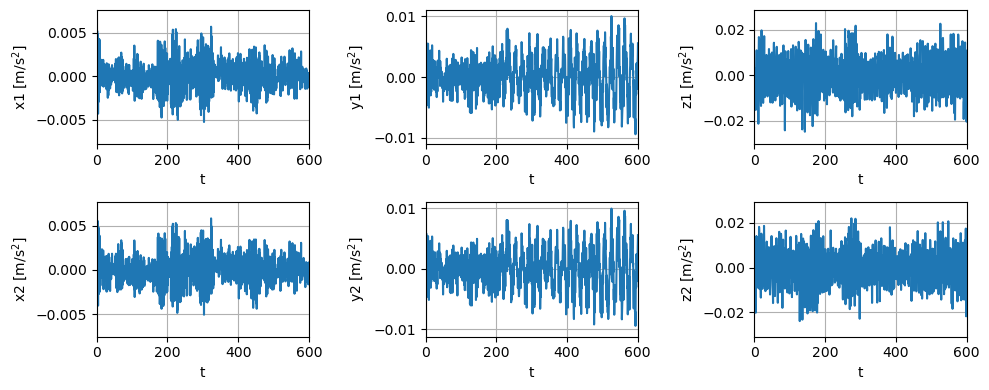

In [1]:
# Import and plot time series

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy import signal as spsi

# Import data x1, y1, and z1
data_labels=np.loadtxt('data/acc_data_hardanger.txt',delimiter=',',skiprows=0, max_rows=1, dtype=str, usecols=[0,1,2,3,4,5,6])

print('Data labels: ')
print(data_labels)

y_labels=data_labels[1:]

t=np.loadtxt('data/acc_data_hardanger.txt',delimiter=',',skiprows=1, usecols=[0]).T # Time vector

y=np.loadtxt('data/acc_data_hardanger.txt',delimiter=',',skiprows=1, usecols=[1,2,3,4,5,6]).T # Acceleration data
 
ym=np.mean(y,axis=1)
y=y-np.atleast_2d(ym).T # Subtract the mean value


dt=t[1]-t[0]
fs=1/dt

print('Sample rate is ' + str(fs) + ' Hz')

# Plot time series
idx=-1
fig, axs = plt.subplots(2,3,figsize=(10,4))
for k1 in np.arange(2):
    for k2 in np.arange(3):
        idx=idx+1
        axs[k1,k2].plot(t,y[idx,:])
        axs[k1,k2].set_ylabel(y_labels[idx] + ' [m/s$^2$]')
        axs[k1,k2].set_xlabel('t')
        axs[k1,k2].grid(True)
        axs[k1,k2].set_xlim(0,600)
plt.tight_layout()


## Welch estimate of cross-spectral density

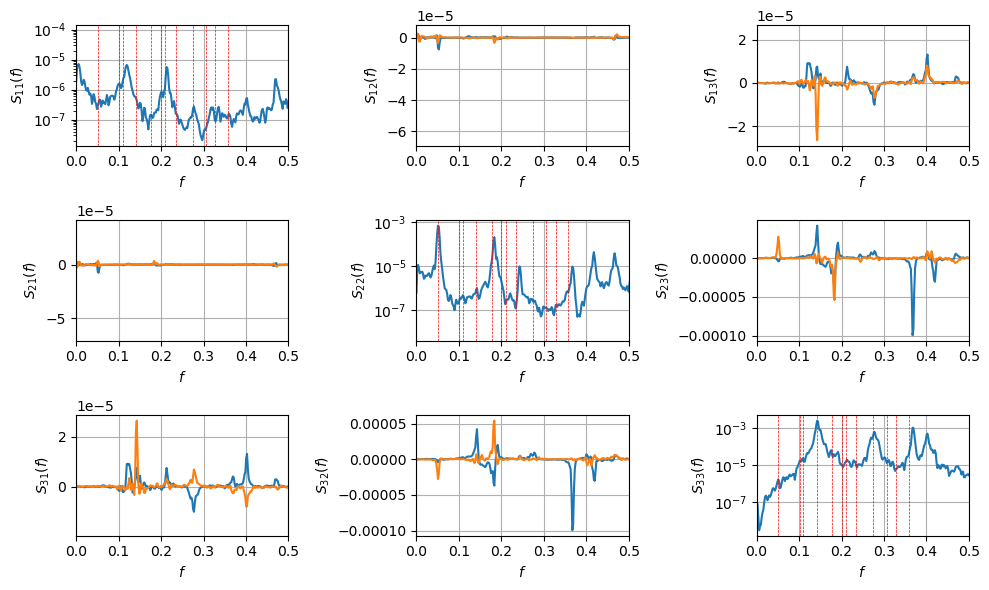

In [3]:
# Welch estimate of cross-spectral density

import scipy

Ndivisions=5 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window
Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2

# Spectral matrix
S_welch=np.zeros((6,6,np.int32(Nfft_pow2/2+1)),dtype=np.complex128)

# Fill spectral matrix by taking the cross spectral density between each of the 6 time series
for k1 in range(6):
    for k2 in range(6):
            f_welch, S_tmp=scipy.signal.csd(y[k1,:],y[k2,:], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
            S_welch[k1,k2,:]=S_tmp
        
# Plot spectrum
fig, axs = plt.subplots(3,3,figsize=(10,6))    
for k1 in range(3):
    for k2 in range(3):
        ax = axs[k1,k2]
        
        ax.plot(f_welch,np.real(S_welch[k1,k2,:])) # Plot real part
        
        if k1!=k2:
            ax.plot(f_welch,np.imag(S_welch[k1,k2,:])) # Plot imaginary part (only for cross spectra)
        
        ax.set_ylabel(('$S_{' + str(k1+1) + str(k2+1) + '}(f)$'))
        ax.set_xlabel('$f$')
        ax.grid(True)
        
        if k1==k2:
            ax.set_yscale('log')
            
        ax.set_xlim(0,0.5)
plt.tight_layout()


fn_model=np.array([0.051,0.101,0.110,0.141,0.177,0.200,0.210,0.234,0.274,0.306,0.328,0.358]) # Frequencies from fe model

# Plot frequencies in spectrum
for k1 in range(3):
        for n in range(len(fn_model)):
            axs[k1,k1].axvline(fn_model[n],color ='r',linewidth=0.5,linestyle='--')



## A closer look at bending and torsional modes

Most structures, bridges and buildings with regular geometries, can be analyzed using the reference figure below.

<center>
<img src="figures\Coordinate_transformation.svg">
</center>

The lower vibration modes of these structures typically fall into one of the following categories:

- *i)* a bending mode about the weak axis
- *ii)* a bending mode about the strong axis
- *iii)* a torsional mode.

Note that classifying modes of very high order or structures with more complex geometries or without clear symmetries becomes more difficult.

If we place a pair of sensors (accelerometers) at the left/right edges of the structure, we can transform their data to a reference point in the center of the bridge:

$$
\left[ \begin{array}{c}
y(t) \\
z(t) \\
\theta(t)
\end{array} \right] =
\underbrace{
\left[ \begin{array}{cccccc}
0 & \dfrac{1}{2} & 0 & 0 & \dfrac{1}{2} & 0 \\
0 & 0 & \dfrac{1}{2} & 0 & 0 & \dfrac{1}{2} \\
0 & 0 & -\dfrac{1}{L} & 0 & 0 & \dfrac{1}{L} \\
\end{array} \right]
}
_{\mathbf{T}}
\left[ \begin{array}{c}
x_1(t) \\
y_1(t) \\
z_1(t) \\
x_2(t) \\
y_2(t) \\
z_2(t) 
\end{array} \right]
$$

These 3 new degrees of freedom will contain contributions from just one of the mode types listed above. This type of transformation can be convenient in order to understand which natural frequency belong to which mode type.

We can either transform the time series, or transform the cross-spectral density matrix of the original degrees of freedom:

$$
\mathbf{S}_m(\omega)= \mathbf{T} \mathbf{S}(\omega)  \mathbf{T}^\text{T}
$$

where $\mathbf{T}$ is the $3\times6$ transformation matrix and $\mathbf{S}_m(\omega)$ is a $3\times 3$ matrix for the middle point.

In [ ]:
L = 13.7 # Distance between sensor 1 and 2

T = np.array([
    [0, 1/2, 0, 0, 1/2, 0],
    [0, 0, 1/2, 0, 0, 1/2],
    [0, 0, -1/L, 0, 0, 1/L]
])

S_mid=np.zeros((3,3,len(f_welch)),dtype='complex')
for k in np.arange(len(f_welch)):
    S_mid[:,:,k]=T @ S_welch[:,:,k] @ T.T # Transform spectrum

m_labels=['y' , 'z' , r'\theta ']
    
# Plot spectrum
fig, axs = plt.subplots(3,3,figsize=(10,6))    
for k1 in range(3):
    for k2 in range(3):
        ax = axs[k1,k2]
        
        ax.plot(f_welch,np.real(S_mid[k1,k2,:])) # Plot real part
        
        if k1!=k2:
            ax.plot(f_welch,np.imag(S_mid[k1,k2,:])) # Plot imaginary part (only for cross spectra)
        
        ax.set_ylabel(r'$S_{' + m_labels[k1] + m_labels[k2] + '}(\omega)$')
        #ax.set_ylabel(r'$S_{\theta}(\omega)$')
        #ax.set_ylabel(r'$S_{' + m_labels[k2] + '}(\omega)$')
        ax.set_xlabel(r'$\omega$')
        ax.grid(True)
        
        if k1==k2:
            ax.set_yscale('log')
            
        ax.set_xlim(0,0.5)
plt.tight_layout()

# Plot frequencies in spectrum
#for k1 in range(3):
        #for n in range(len(fn_model)):
            #axs[k1,k1].axvline(fn_model[n],color ='r',linewidth=0.5,linestyle='--')



These result are easier to interpret. We clearly see that the lowest bridge mode is a lateral bending mode, which peaks at $0.05$ Hz for $S_{yy}(\omega)$.

The first torsional mode is located at around $0.35$ Hz, as seen in $S_{\theta \theta}(\omega)$.

There are no peaks for the two red lines around $0.1$ Hz, why?